In [1]:
#from create_maps import *
import numpy as np
import nibabel.freesurfer.io as fsio
from functools import reduce
import nibabel as nib
import numpy as np
from nilearn import plotting
import os
from scipy import stats

lh_f = "/home/wsm32/project/wsm_thesis_scratch/narratives/fs6_transfer/label/lh.aparc.a2009s.annot"
rh_f = "/home/wsm32/project/wsm_thesis_scratch/narratives/fs6_transfer/label/rh.aparc.a2009s.annot"

def load_annot_to_full_binary_dict(lh_annot_file, rh_annot_file):
    """
    Load left and right hemisphere .annot files and create a dictionary of binary maps
    for regions in the full fsaverage6 surface space (81,924 vertices total).

    Each binary map is of shape (81924,), with the left hemisphere occupying the first 40962 indices,
    and the right hemisphere occupying the last 40962 indices. Non-relevant hemisphere regions are zero-padded.

    Parameters:
    - lh_annot_file: Path to the left hemisphere .annot file.
    - rh_annot_file: Path to the right hemisphere .annot file.

    Returns:
    - region_dict: Dictionary where keys are region names (prefixed with L_ or R_) and values are binary arrays.
    """
    region_dict = {}
    num_vertices = 40962  # fsaverage6 has 40,962 vertices per hemisphere

    # Left hemisphere
    lh_labels, _, lh_names = fsio.read_annot(lh_annot_file)
    for i, name in enumerate(lh_names):
        binary_lh = (lh_labels == i).astype(int)
        if np.any(binary_lh):  # only add if there are non-zero values
            region_name = f"L_{name.decode('utf-8')}"
            binary_full = np.concatenate([binary_lh, np.zeros(num_vertices, dtype=int)])
            region_dict[region_name] = binary_full

    # Right hemisphere
    rh_labels, _, rh_names = fsio.read_annot(rh_annot_file)
    for i, name in enumerate(rh_names):
        binary_rh = (rh_labels == i).astype(int)
        if np.any(binary_rh):  # only add if there are non-zero values
            region_name = f"R_{name.decode('utf-8')}"
            binary_full = np.concatenate([np.zeros(num_vertices, dtype=int), binary_rh])
            region_dict[region_name] = binary_full

    return region_dict


region_dict = load_annot_to_full_binary_dict(lh_f, rh_f)

fsaverage_dir = "/home/wsm32/project/wsm_thesis_scratch/narratives/fs6_transfer"
lh_pial = os.path.join(fsaverage_dir, "surf", "lh.pial")
rh_pial = os.path.join(fsaverage_dir, "surf", "rh.pial")


large_baseline = "/home/wsm32/project/wsm_thesis_scratch/narratives/rt_large/0.001-0.5-2-128-0.05-8-16/best_model.pt"
small_baseline = "/home/wsm32/project/wsm_thesis_scratch/narratives/rt_large/0.001-0.5-1-64-0.05-4-16/best_model.pt"


def load_embeds(this_file):
    m = torch.load(this_file, map_location=torch.device('cpu'))['model']
    return m["module.encoder.en_emd.weight"].numpy()

def region_similarity(embeds, strategy, region):
    weights_sq = embeds ** 2
    #print(weights_sq.shape)
    #print(region.shape)
    results = ((weights_sq) @ region) / np.linalg.norm(region)
    results = results / np.linalg.norm(weights_sq, axis = 1)
    return strategy(results)

def plot_regions_html(regions, filename):
    to_plot = reduce(np.bitwise_or, [region_dict[region] for region in regions])
    fsaverage_dir = "/home/wsm32/project/wsm_thesis_scratch/narratives/fs6_transfer"

    lh_pial = os.path.join(fsaverage_dir, "surf", "lh.pial")
    rh_pial = os.path.join(fsaverage_dir, "surf", "rh.pial")

    # Your data array
    # Replace this with your actual data, ensure it's the right length
    data_l = to_plot[0:40962] 
    data_r = to_plot[40962:] 

    # Load surfaces
    lh_coords, lh_faces = nib.freesurfer.read_geometry(lh_pial)
    rh_coords, rh_faces = nib.freesurfer.read_geometry(rh_pial)

    # Visualize left hemisphere
    view = plotting.view_surf((lh_coords, lh_faces), surf_map=data_l, cmap='viridis')
    view.save_as_html(f"{filename}_left.html")

    view = plotting.view_surf((rh_coords, rh_faces), surf_map=data_r, cmap='viridis')
    view.save_as_html(f"{filename}_right.html")


def plot_regions(regions):
    to_plot = reduce(np.bitwise_or, [region_dict[region] for region in regions])
    fsaverage_dir = "/home/wsm32/project/wsm_thesis_scratch/narratives/fs6_transfer"

    lh_pial = os.path.join(fsaverage_dir, "surf", "lh.pial")
    rh_pial = os.path.join(fsaverage_dir, "surf", "rh.pial")

    data_l = to_plot[:40962]
    data_r = to_plot[40962:]

    lh_coords, lh_faces = nib.freesurfer.read_geometry(lh_pial)
    rh_coords, rh_faces = nib.freesurfer.read_geometry(rh_pial)

    # Convert binary to float for plotting (0.0 or 1.0)
    data_l = data_l.astype(float)
    data_r = data_r.astype(float)

    # Plot all 4 views
    hemis = [('left', lh_coords, lh_faces, data_l), ('right', rh_coords, rh_faces, data_r)]
    views = ['lateral', 'medial']

    for hemi_name, coords, faces, data in hemis:
        for view in views:
            plotting.plot_surf_stat_map(
                surf_mesh=(coords, faces),
                stat_map=data,
                hemi=hemi_name,
                view=view,
                colorbar=False,
                bg_map=None,
                cmap='viridis',
                title=f'{hemi_name.capitalize()} Hemisphere - {view.capitalize()} View'
            )
    plt.show()


In [2]:
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator
from pathlib import Path

def load_scalars_to_df(summary_dir, reload=True):
    """
    Load scalar logs from a TensorBoard summary directory into a DataFrame.

    Parameters:
    - summary_dir (str or Path): Path to directory containing event files.
    - reload (bool): Whether to call Reload() on the event accumulator.

    Returns:
    - df (pd.DataFrame): DataFrame with one column per scalar tag and rows indexed by step.
    """
    summary_dir = Path(summary_dir)
    
    # Locate the event file (assumes only one or takes the first)
    event_files = list(summary_dir.glob("**/events.out.tfevents.*"))
    if not event_files:
        raise FileNotFoundError(f"No event files found in {summary_dir}")
    
    ea = event_accumulator.EventAccumulator(str(event_files[0]))
    if reload:
        ea.Reload()
    
    scalars_by_tag = {}
    for tag in ea.Tags().get('scalars', []):
        events = ea.Scalars(tag)
        scalars_by_tag[tag] = pd.Series(
            data=[e.value for e in events],
            index=[e.step for e in events],
            name=tag
        )
    
    # Merge all Series into a single DataFrame on the step index
    df = pd.concat(scalars_by_tag.values(), axis=1)
    df.index.name = "step"
    
    return df.reset_index()


Autoencoder Hyperparameter Analysis

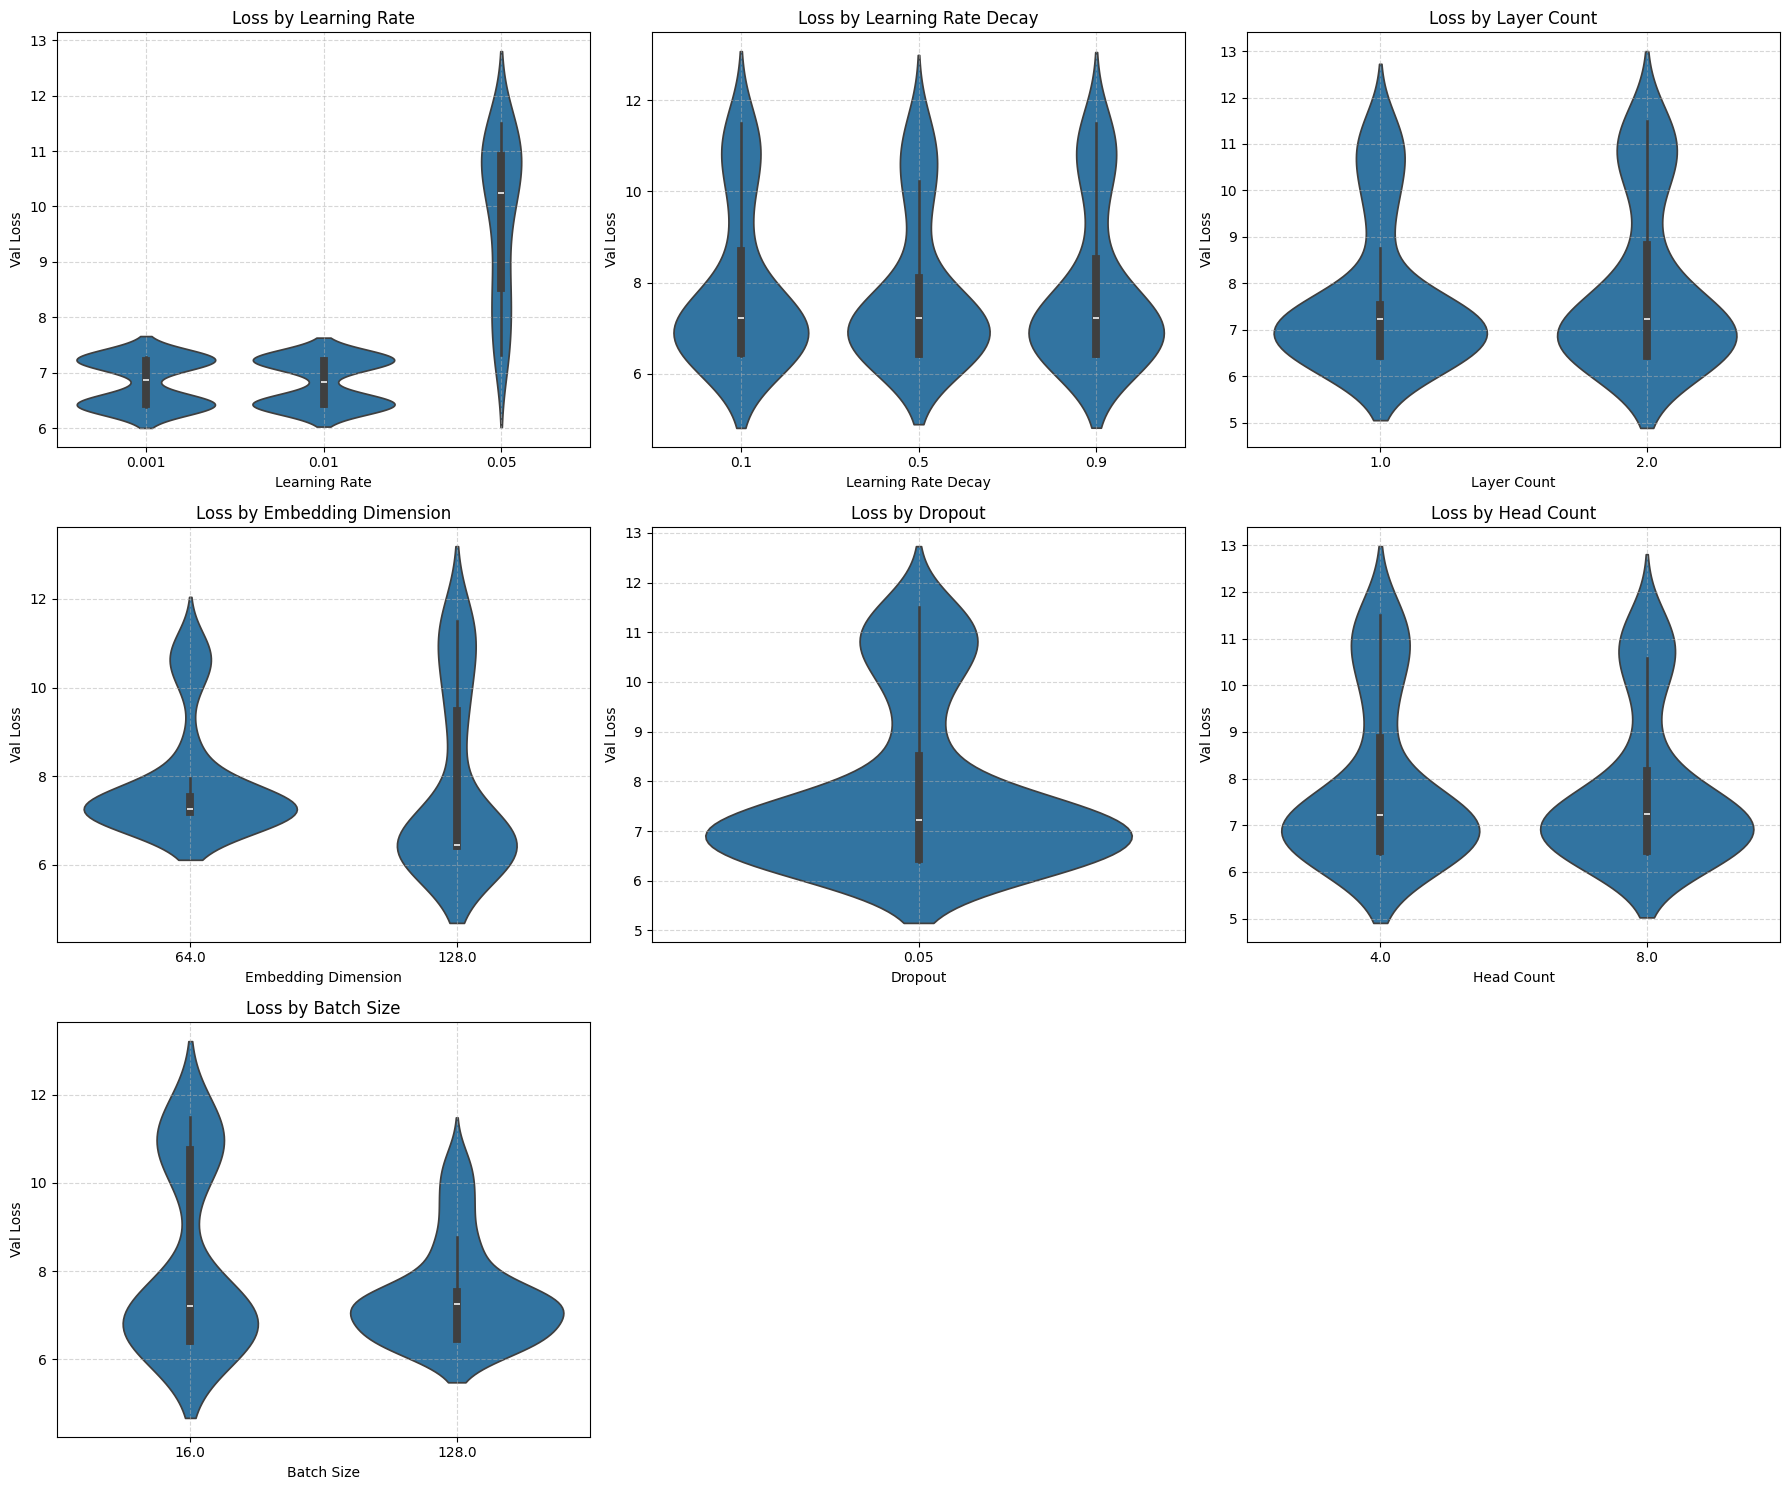

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

autoencoder_dir = Path("/home/wsm32/project/wsm_thesis_scratch/narratives/rt_large")
param_names = ["lr", "lr_decay", "layer_count", "latent", "dropout", "head_count", "batch_size"]
full_pnames = ["Learning Rate", "Learning Rate Decay", "Layer Count", "Embedding Dimension", "Dropout", "Head Count", "Batch Size"]

ae_info = pd.DataFrame(columns=param_names + ["val_loss"])

for subdir in autoencoder_dir.iterdir():
    if subdir.is_dir() and "0.0" in str(subdir):
        train_info = load_scalars_to_df(subdir / "summary")
        val_minloss = train_info["Val_Loss"].min()
        toks = [float(x) for x in subdir.name.split("-")]
        ae_info.loc[len(ae_info)] = toks + [val_minloss]

# Plot all in one 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, (pn, nn) in enumerate(zip(param_names, full_pnames)):
    sns.violinplot(x=pn, y="val_loss", data=ae_info, ax=axes[i])
    axes[i].set_title(f"Loss by {nn}")
    axes[i].set_xlabel(nn)
    axes[i].set_ylabel("Val Loss")
    axes[i].grid(True, linestyle="--", alpha=0.5)

# Hide any unused subplots
for j in range(len(param_names), 9):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("figures/AE/AE_violin_grid.png", dpi=300, bbox_inches="tight")
plt.show()


Predictor Hyperparameter Analysis

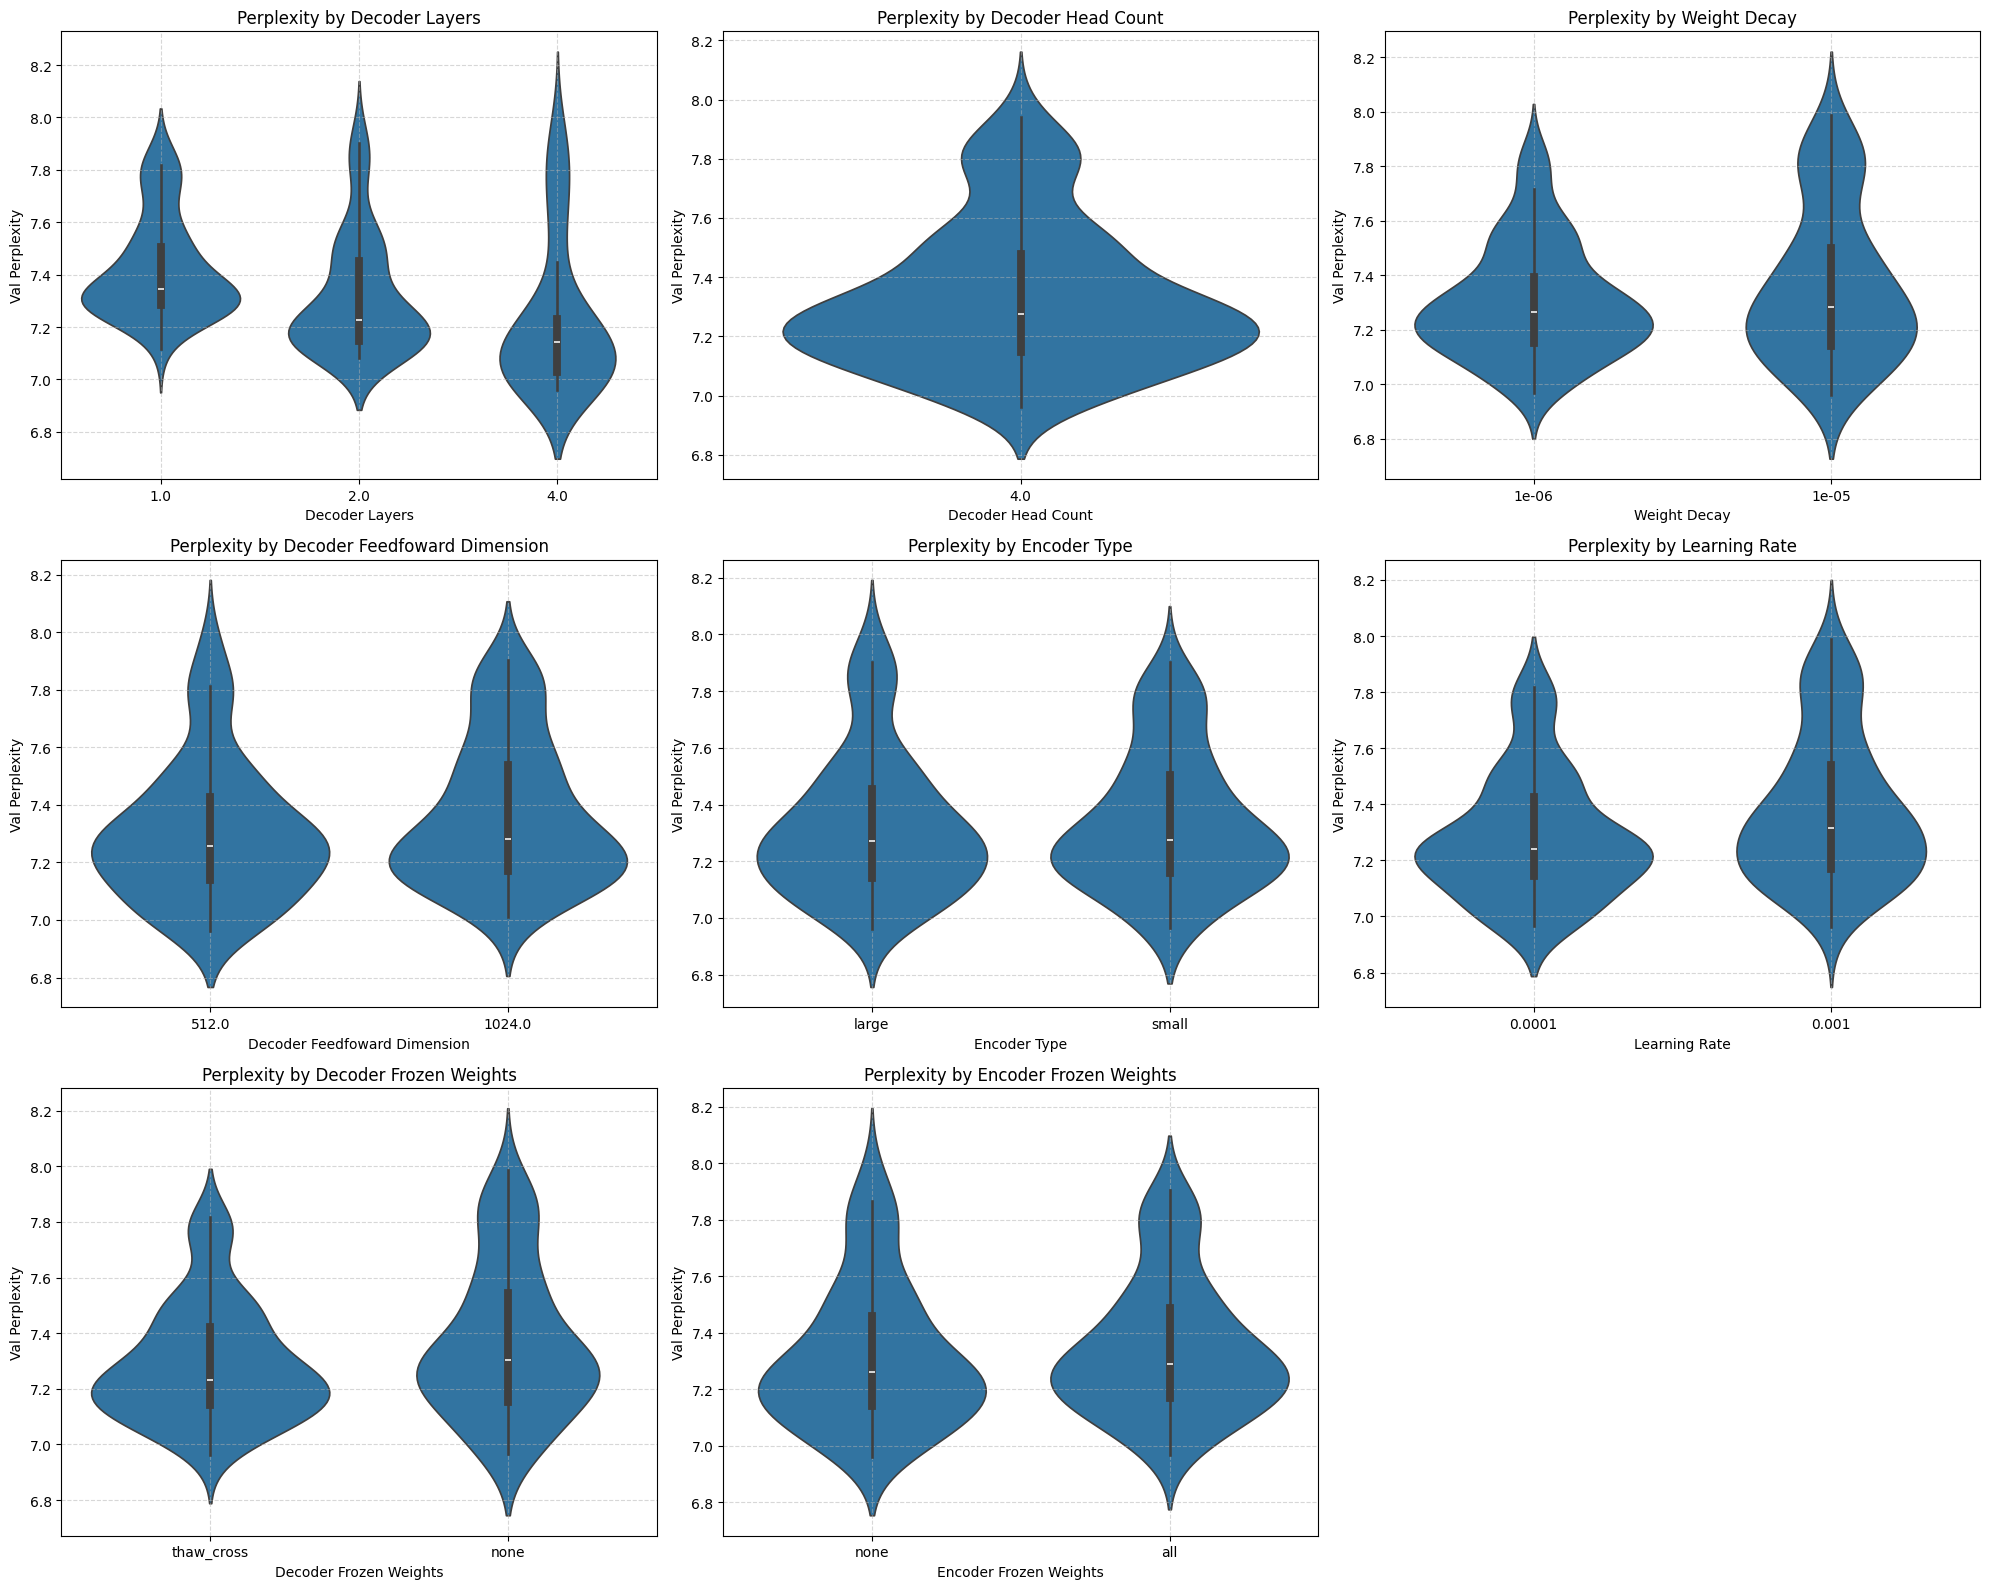

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

def try_float(tok):
    try:
        return float(tok)
    except ValueError:
        return tok

predictor_dir = Path("/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/predictors")
param_names = ["dec_blocks", "n_dec_head", "wd", "dec_ff", "encoder['kind']", "lr", "df", "enf"]
full_pnames = ["Decoder Layers", "Decoder Head Count", "Weight Decay", "Decoder Feedfoward Dimension",
               "Encoder Type", "Learning Rate", "Decoder Frozen Weights", "Encoder Frozen Weights"]

ae_info = pd.DataFrame(columns=param_names + ["val_perp"])

for subdir in predictor_dir.iterdir():
    if subdir.is_dir():
        train_info = load_scalars_to_df(subdir / "summary")
        val_perp = train_info.loc[train_info["Val_Loss"].idxmin(), "Val_Perp"]
        toks = [try_float(tok) for tok in subdir.name.split("-")]
        ae_info.loc[len(ae_info)] = toks + [val_perp]

# Plot in a single 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
axes = axes.flatten()

for i, (pn, nn) in enumerate(zip(param_names, full_pnames)):
    sns.violinplot(x=pn, y="val_perp", data=ae_info, ax=axes[i])
    axes[i].set_title(f"Perplexity by {nn}")
    axes[i].set_xlabel(nn)
    axes[i].set_ylabel("Val Perplexity")
    axes[i].grid(True, linestyle="--", alpha=0.5)

# Remove any unused subplots
for j in range(len(param_names), 9):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("figures/predictor/Predictor_violin_grid.png", dpi=300, bbox_inches="tight")
plt.show()


Pretraining Curve

/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/decoder_bases/2-8-0.000001-512-large-0.0001
/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/decoder_bases/1-4-0.000001-512-small-0.0001
/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/decoder_bases/2-4-0.000010-512-small-0.001
/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/decoder_bases/1-8-0.000010-512-large-0.0001
/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/decoder_bases/4-8-0.000010-512-large-0.001
/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/decoder_bases/4-4-0.000010-1024-small-0.001
/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/decoder_bases/1-4-0.000010-512-small-0.0001
/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/decoder_bases/2-8-0.000001-512-small-0.0001
/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/decoder_bases/1-8-0.000001-1024-small-0.0001
/home/wsm32/project/wsm_thesis_scratch

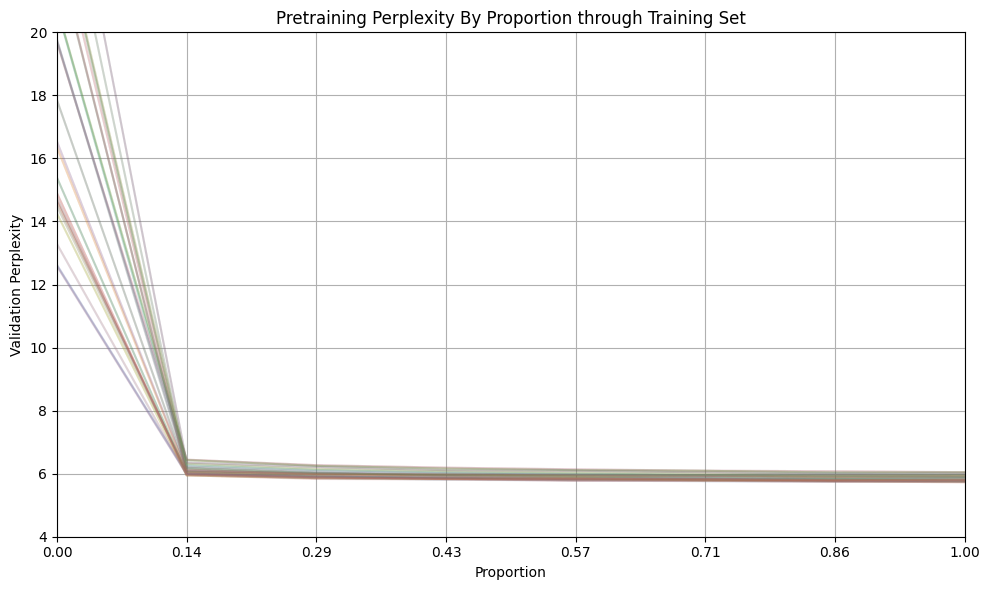

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def try_float(tok):
    try:
        return float(tok)
    except ValueError:
        return tok



predictor_dir = Path("/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/decoder_bases")
param_names = ["dec_blocks", "n_dec_head", "wd", "dec_ff", "encoder['kind']", "lr"]

full_pnames = ["Decoder Layers", "Decoder Head Count", "Weight Decay", "Decoder Feedfoward Dimension","Encoder Type", "Learning Rate"]

ae_info = pd.DataFrame(columns=param_names + ["perp_seq"])

for subdir in predictor_dir.iterdir():
        if subdir.is_dir():
                print(subdir)
                try:
                    train_info = load_scalars_to_df(subdir / "summary")

                    val_perp = train_info["Val_Perp"]
                    toks = subdir.name.split("-")
                    toks = [try_float(tok) for tok in toks]
                    ae_info.loc[len(ae_info)] = toks + [val_perp]
                except:
                    pass

plt.figure(figsize=(10, 6))




for seq in ae_info["perp_seq"]:
    plt.plot(seq.values, alpha=0.1)  # low alpha for transparency
plt.xlim(0, 7) 
plt.ylim(4,20)
plt.xlabel("Proportion")
plt.xticks(range(8),labels=[f"{x/7:.2f}" for x in range(8)])
plt.ylabel("Validation Perplexity")
plt.title("Pretraining Perplexity By Proportion through Training Set")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"figures/Pretrain_{nn}.png", dpi=300, bbox_inches='tight')
plt.show()

Analyzing training curve

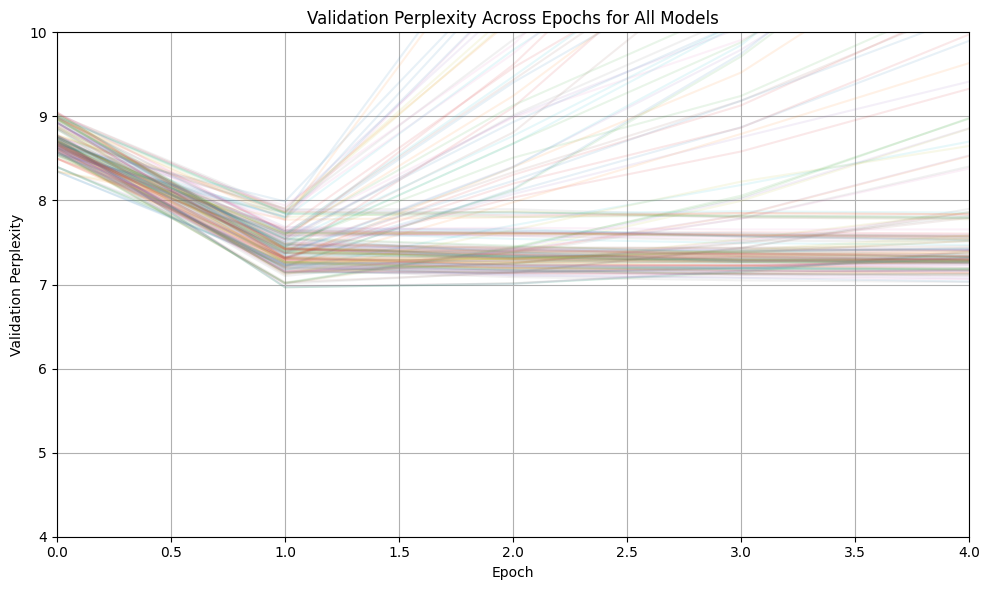

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def try_float(tok):
    try:
        return float(tok)
    except ValueError:
        return tok



predictor_dir = Path("/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/predictors")
param_names = ["dec_blocks", "n_dec_head", "wd", "dec_ff", "encoder['kind']", "lr", "df", "enf"]

full_pnames = ["Decoder Layers", "Decoder Head Count", "Weight Decay", "Decoder Feedfoward Dimension","Encoder Type", "Learning Rate", "Decoder Frozen Weights", "Encoder Frozen Weights"]

ae_info = pd.DataFrame(columns=param_names + ["perp_seq"])

for subdir in predictor_dir.iterdir():
        if subdir.is_dir():
                train_info = load_scalars_to_df(subdir / "summary")

                val_perp = train_info["Val_Perp"]
                toks = subdir.name.split("-")
                toks = [try_float(tok) for tok in toks]
                ae_info.loc[len(ae_info)] = toks + [val_perp]


plt.figure(figsize=(10, 6))




for seq in ae_info["perp_seq"]:
    plt.plot(seq.values, alpha=0.1)  # low alpha for transparency
plt.xlim(0, 4) 
plt.ylim(4,10)
plt.xlabel("Epoch")
plt.ylabel("Validation Perplexity")
plt.title("Validation Perplexity Across Epochs for All Models")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"figures/VP_.png", dpi=300, bbox_inches='tight')
plt.show()

Region Analysis

In [7]:
brocas = ["L_G_front_inf-Opercular", "L_G_front_inf-Triangul"]
broca_map = reduce(np.bitwise_or, [region_dict[region] for region in brocas])

PVC = ["L_S_calcarine", "R_S_calcarine"]
PVC_map = reduce(np.bitwise_or, [region_dict[region] for region in PVC])

cuneus = ["L_G_cuneus", "R_G_cuneus"]
cuneus_map = reduce(np.bitwise_or, [region_dict[region] for region in cuneus])

stg = ["L_G_temp_sup-Lateral","L_G_temp_sup-Plan_tempo","L_G_temp_sup-Plan_polar","L_G_temp_sup-G_T_transv"]
stg_map = reduce(np.bitwise_or, [region_dict[region] for region in stg])


In [8]:
print([np.sum(x) for x in region_dict.values()])

[np.int64(234), np.int64(353), np.int64(631), np.int64(578), np.int64(145), np.int64(653), np.int64(498), np.int64(608), np.int64(249), np.int64(141), np.int64(360), np.int64(466), np.int64(117), np.int64(261), np.int64(1047), np.int64(2021), np.int64(209), np.int64(226), np.int64(506), np.int64(346), np.int64(441), np.int64(619), np.int64(575), np.int64(614), np.int64(744), np.int64(1129), np.int64(1006), np.int64(896), np.int64(990), np.int64(894), np.int64(292), np.int64(62), np.int64(193), np.int64(668), np.int64(215), np.int64(345), np.int64(648), np.int64(695), np.int64(108), np.int64(95), np.int64(493), np.int64(3486), np.int64(449), np.int64(415), np.int64(788), np.int64(1198), np.int64(490), np.int64(221), np.int64(553), np.int64(755), np.int64(231), np.int64(83), np.int64(566), np.int64(373), np.int64(787), np.int64(131), np.int64(1108), np.int64(249), np.int64(326), np.int64(214), np.int64(231), np.int64(650), np.int64(78), np.int64(197), np.int64(302), np.int64(544), np.int

In [9]:
from pathlib import Path
import torch
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter("ignore", FutureWarning)
root_dir = Path("/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/predictors")
region_masks = np.stack(list(region_dict.values()))
#print("Baseline", compute_broca_sim(large_baseline, np.mean))

def topk_mean(arr, k):
    """
    Returns the mean of the top k elements of the array.
    
    Parameters:
        arr (array-like): Input array.
        k (int): Number of top elements to average.
    
    Returns:
        float: Mean of the top k elements.
    """
    arr = np.asarray(arr)
    if k <= 0:
        raise ValueError("k must be positive.")
    if k > arr.size:
        raise ValueError("k cannot be larger than the number of elements in the array.")
    
    # Use np.partition to efficiently find the top k
    top_k = np.partition(arr, -k)[-k:]
    return np.mean(top_k)
top_10 = lambda x: topk_mean(x,10)


model_mean_bs = []
model_mean_pvc = []
model_mean_cuneus = []
model_mean_stg = []

model_max_bs = []
model_min_perp = []

all_models = pd.DataFrame(columns=["name","embeds","train_info","region_scores","min_perp"])


for subdir in root_dir.iterdir():
        if subdir.is_dir() and ("thaw_cross-none" in str(subdir) or "none-none" in str(subdir)) and "large" in str(subdir):
            comp_model = subdir / "best_predictor_model.pt"
            embeds = load_embeds(comp_model)
            #print("Directory:", subdir)

            #model_mean_bs.append(region_similarity(embeds, top_10, broca_map))
            #model_mean_pvc.append(region_similarity(embeds, top_10, PVC_map))
            #model_mean_cuneus.append(region_similarity(embeds, top_10, cuneus_map))
            #model_mean_stg.append(region_similarity(embeds, top_10, stg_map))

            #model_max_bs.append(compute_broca_sim(comp_model, np.max))
            
            train_info = load_scalars_to_df(subdir/ "summary")
            mp = train_info.loc[train_info["Val_Loss"].idxmin(), "Val_Perp"]
            #model_min_perp.append(mp)

            sq_embeds = embeds**2
            region_dps = region_masks @ sq_embeds.T # Dot products with squared weights
            print(region_dps.shape)
            #print(np.linalg.norm(region_masks, axis=1)[:,128].shape)
            region_dps_scaled = (region_dps / np.linalg.norm(region_masks, axis=1)[:,None]) / np.linalg.norm(sq_embeds, axis=1)[None,:]



            all_models.loc[len(all_models)] = [str(subdir), embeds, train_info, np.mean(region_dps_scaled, axis=1), mp]
            
        #break


(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)
(150, 128)


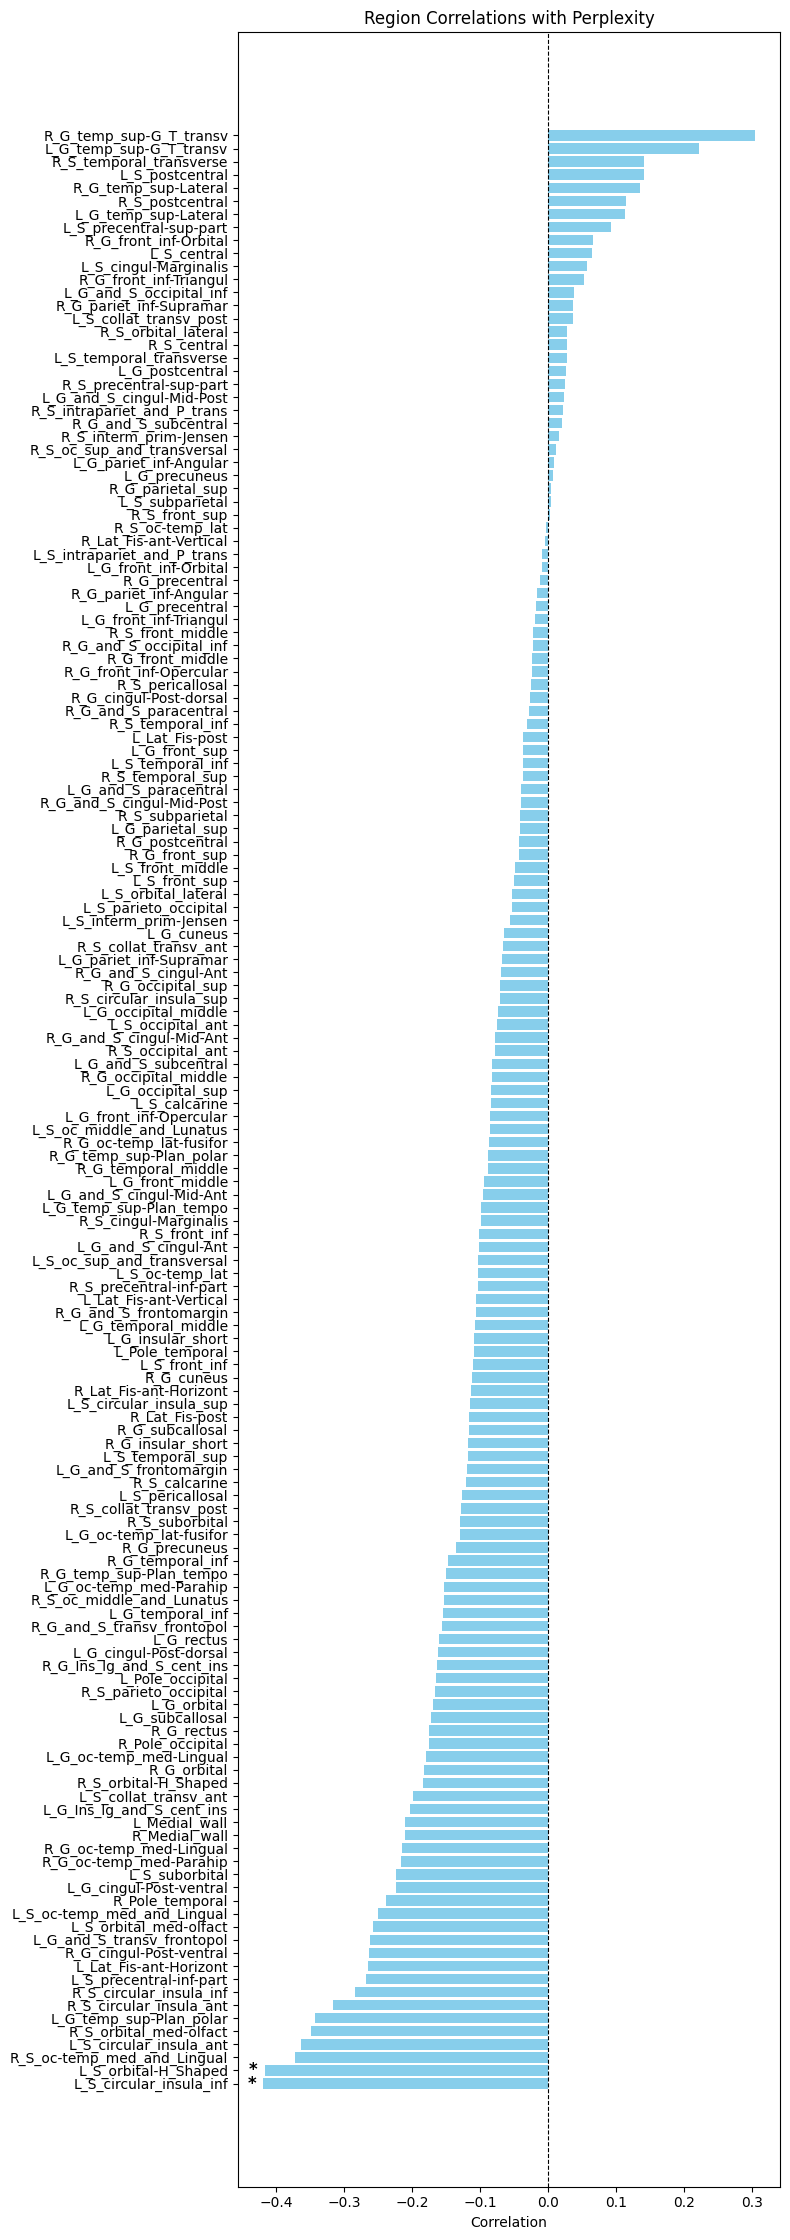

[0.36710276 0.36710276 0.57484953 0.57484953 0.57484953 0.57484953
 0.78600084 0.97832719 0.97832719 0.97832719 0.97832719 0.97832719
 0.97832719 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731
 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731
 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731
 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731
 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731
 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731
 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731
 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731
 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731
 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731
 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731
 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731
 0.98917731 0.98917731 0.98917731 0.98917731 0.98917731 0.9891

In [10]:
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

region_corrs = {}

for i in range(len(region_dict)):
    minimum_perplexities = list(all_models["min_perp"])
    sims = all_models["region_scores"].apply(lambda x: x[i]).values
    #print(sims)
    if not np.all(sims == sims.flat[0]):
        c, p = pearsonr(minimum_perplexities, sims)
        region_corrs[list(region_dict.keys())[i]] = (c,p)
    else:
        print(list(region_dict.keys())[i])

    #print(f"{list(region_dict.keys())[i]} {c}")


# Sort by correlation values
sorted_items = sorted(region_corrs.items(), key=lambda x: x[1][0])
labels = [k for k, v in sorted_items]
values = [v[0] for _, v in sorted_items]
p_values = [v[1] for _, v in sorted_items]

# Plot
fig, ax = plt.subplots(figsize=(8, len(labels) * 0.15))
y_pos = range(len(labels))
bars = ax.barh(y_pos, values, color='skyblue')

# Add zero line
ax.axvline(0, color='black', linewidth=0.8, linestyle='--')

# Add stars at the end of significant bars
for i, (val, p) in enumerate(zip(values, p_values)):
    if p < 0.01:
        ha = 'left' if val >= 0 else 'right'
        x_offset = 0.01 if val >= 0 else -0.01
        ax.text(val + x_offset, i, '*', va='center', ha=ha, fontsize=12, fontweight='bold')

# Labels and layout
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel("Correlation")
ax.set_title("Region Correlations with Perplexity")
plt.tight_layout()
plt.savefig(f"figures/corr_analysis.png", dpi=300, bbox_inches='tight')
plt.show()



signif_negs = []
for k, v in region_corrs.items():
    if v[1] < 0.005 and v[0] < 0:
        signif_negs += [k]
#print(signif_negs)
plot_regions_html(signif_negs, "signif_regions")
print(stats.false_discovery_control(p_values))
print(p_values)


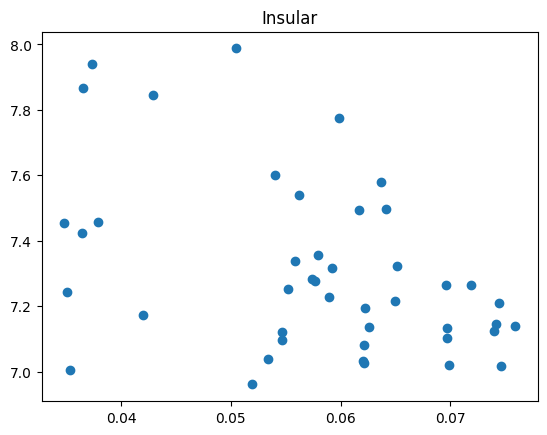

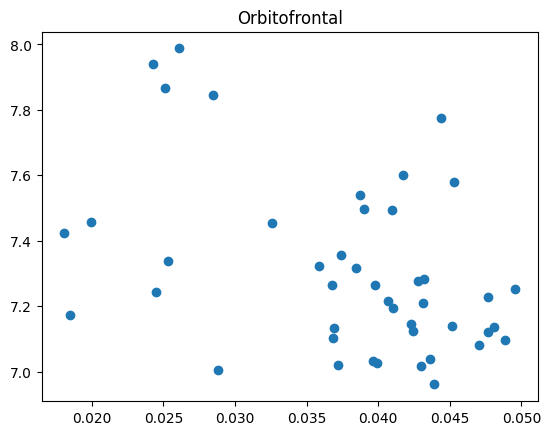

In [11]:
i = list(region_dict.keys()).index("L_S_circular_insula_inf")
minimum_perplexities = list(all_models["min_perp"])
sims = all_models["region_scores"].apply(lambda x: x[i]).values
plt.scatter(sims, minimum_perplexities)
plt.title("Insular")
plt.show()

i = list(region_dict.keys()).index("L_S_orbital-H_Shaped")
minimum_perplexities = list(all_models["min_perp"])
sims = all_models["region_scores"].apply(lambda x: x[i]).values
plt.scatter(sims, minimum_perplexities)
plt.title("Orbitofrontal")
plt.show()

In [17]:
all_models.head()
def get_final_perp(train_info):
    return train_info.loc[train_info["Val_Loss"].idxmin(), "Val_Perp"]
final_perps = all_models["train_info"].apply(get_final_perp)
print(final_perps.nsmallest(10))
best_embeds = all_models.loc[final_perps.nsmallest(5).index, "embeds"]
worst_embeds = all_models.loc[final_perps.nlargest(5).index, "embeds"]

be = best_embeds.apply(lambda x: np.mean(x**2, axis=0))
be = np.mean(np.stack(be.values), axis = 0)

wo = worst_embeds.apply(lambda x: np.mean(x**2, axis=0))
wo = np.mean(np.stack(wo.values), axis = 0)

lh_coords, lh_faces = nib.freesurfer.read_geometry(lh_pial)
rh_coords, rh_faces = nib.freesurfer.read_geometry(rh_pial)

# Visualize left hemisphere
view = plotting.view_surf((lh_coords, lh_faces), surf_map=(be-wo)[:40962], cmap='viridis')

view.save_as_html("delta_output_5l.html")

view = plotting.view_surf((rh_coords, rh_faces), surf_map=(be-wo)[40962:], cmap='viridis')

view.save_as_html("delta_output_5r.html")


16    6.960654
4     7.004727
26    7.015849
5     7.021668
41    7.027455
40    7.031266
6     7.039165
37    7.080696
38    7.095644
11    7.101473
Name: train_info, dtype: float64


In [18]:
from pathlib import Path
import torch
import warnings
import re
import json
import matplotlib.pyplot as plt
def extract_json_from_output(output: str) -> str:
    pattern = r"PERM_BEGIN\s*(.*?)\s*PERM_END"
    match = re.search(pattern, output, re.DOTALL)
    if not match:
        raise ValueError("Markers PERM_BEGIN and PERM_END not found.")
    return match.group(1)


warnings.simplefilter("ignore", FutureWarning)
root_dir = Path("/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/predictors")
perm_test_dir = Path("/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/perm_testing")

default_perp = []
perm_perp = []


ptest_succ = 0

for subdir in root_dir.iterdir():
        if subdir.is_dir():# and ("thaw_cross-none" in str(subdir) or "none-none" in str(subdir)): and "0.001" in str(subdir):
            comp_model = subdir / "best_predictor_model.pt"
            #print("Directory:", subdir)

            train_info = load_scalars_to_df(subdir/ "summary")
            model_step = train_info["Val_Loss"].idxmin()
            default_perp += [train_info.loc[model_step, "Val_Perp"]]

            try:
                with open(str(perm_test_dir) +"/"+ (str(subdir.name) + ".txt"), "r") as f:
                    obj = json.loads(extract_json_from_output(f.read()))
                    perm_perp += [obj["perp"]]
            except Exception as e:
                print(f"Error processing: {e}")

        #break
print(len(perm_perp))
print(len(default_perp))

perm_diff = [perm_perp[a] - default_perp[a] for a in range(len(perm_perp))]
print(np.mean(perm_diff))
print(len(perm_diff))

177
177
0.03484216887798347
177


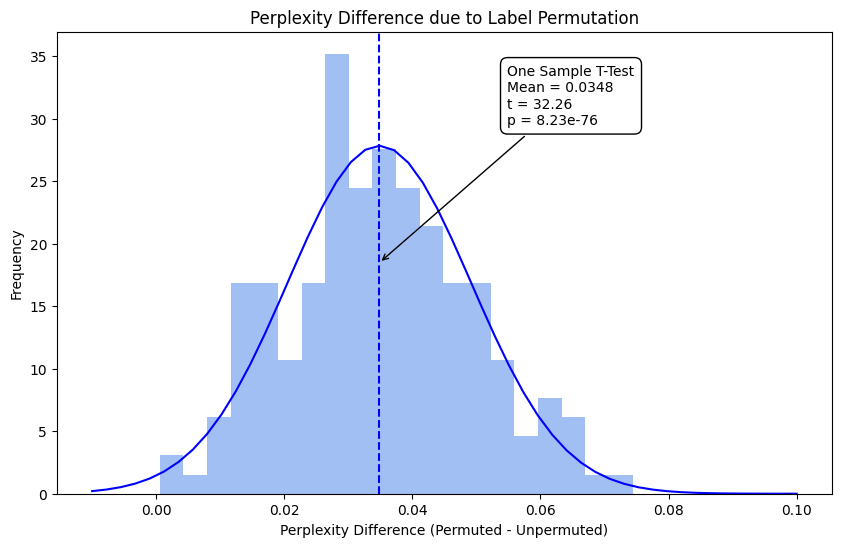

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_1samp

# Example data
# perm_diff = np.random.normal(loc=0.02, scale=0.01, size=100)  # Replace with your data

# One-sample t-test
t_stat, p_value = ttest_1samp(perm_diff, popmean=0)
mean_val = np.mean(perm_diff)

# Plot
plt.figure(figsize=(10, 6))
x = np.linspace(-0.01, 0.1)
plt.hist(perm_diff, bins=20, density=True, alpha=0.6, color='cornflowerblue')
plt.plot(x, norm.pdf(x, mean_val, np.std(perm_diff)), color="blue")
mean_line = plt.axvline(mean_val, color="blue", linestyle="--")

# Annotation text
textstr = (
    "One Sample T-Test\n"
    f"Mean = {mean_val:.4f}\n"
    f"t = {t_stat:.2f}\n"
    f"p = {p_value:.3g}"
)

# Annotate with arrow pointing to mean line
plt.annotate(
    textstr,
    xy=(mean_val, plt.ylim()[1]*0.5),      # Arrow target
    xytext=(mean_val + 0.02, plt.ylim()[1]*0.8),  # Box position
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    bbox=dict(boxstyle="round,pad=0.5", edgecolor='black', facecolor='white'),
    ha='left'
)

plt.title("Perplexity Difference due to Label Permutation")
plt.xlabel("Perplexity Difference (Permuted - Unpermuted)")
plt.ylabel("Frequency")
plt.savefig(f"figures/Perm_{nn}.png", dpi=300, bbox_inches='tight')
plt.show()
